In [107]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import pickle
from glob import glob
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [108]:
def data_load(train_path, indices, use_lane = False, use_vel = False):

    pkl_list = glob(os.path.join(train_path, "*.pkl"))
    pkl_list.sort()

    data = []
    label = []

    for i in indices:
        with open(pkl_list[i], 'rb') as f:
            scene = pickle.load(f)
        
        
        min_vecs = scene['normalize_min']  
        max_vecs = scene['normalize_max']

        inp = scene['inp_scene'][:, :2]
        out = scene['out_scene'][:, :2]

        
        inp = inp * (max_vecs[:2] - min_vecs[:2]) + min_vecs[:2]
        out = out * (max_vecs[:2] - min_vecs[:2]) + min_vecs[:2]
        init_pose = inp[0, :2]

        if use_lane:
            inp = np.concatenate([inp, scene['lane']], axis = 0)

        if use_vel:
            inp = scene['inp_scene']
            out = scene['out_scene'][:, :2]

            inp = inp * (max_vecs - min_vecs) + min_vecs
            out = out * (max_vecs[:2] - min_vecs[:2]) + min_vecs[:2]
        
        inp = inp[:, :2] - init_pose
        out = out[:, :2] - init_pose

        data.append(inp)
        label.append(out)
    
    max_size = 0
    for i in range(len(data)):
        if max_size < len(data[i]):
            max_size = len(data[i])

    if use_lane:
        for i in range(len(data)):
            data[i] = np.concatenate([data[i], np.zeros((max_size - len(data[i]), 2))], axis = 0)
            label[i] = np.concatenate([label[i], np.zeros((max_size - len(label[i]), 2))], axis = 0)


    data = np.array(data)
    label = np.array(label)

    return data, label

In [109]:
path = "./../data/prep_1/train"
indices = np.arange(0, 205942)

In [110]:
pose_data, pose_label = data_load(path, indices)
pose_vel_data, pose_vel_label = data_load(path, indices, False, True)

In [111]:
batch_size = 512
pose_in = 19 * 2
pose_out = 30 * 2
hidden_dim = 256
num_layers = 4
learning_rate = 0.01
decay_rate = 0.95
num_epoch = 500

In [112]:
class MLPNet(nn.Module):
    def __init__(self, 
                 in_dim, # input dimension
                 out_dim, # output dimension
                 hidden_dim, # hidden dimension
                 num_layers # number of layers
                ):
        
        super(MLPNet, self).__init__()
        
        self.model = [nn.Linear(in_dim, hidden_dim), nn.ReLU()]
        
        for i in range(num_layers-2):
            self.model += [nn.Linear(hidden_dim, hidden_dim), nn.ReLU()]
        
        self.model += [nn.Linear(hidden_dim, out_dim)]
        
        self.model = nn.Sequential(*self.model)
        
    def forward(self, inp):
        
        # Flatten the last two dimensions
        inp = inp.reshape(inp.shape[0], -1)
        
        out = self.model(inp)
        
        #bz x outputlength x 2
        return out.reshape(inp.shape[0], -1, 2)

In [113]:
indices = np.arange(0, pose_data.shape[0])

In [114]:
train_indices = indices[:int(len(indices) * 0.8)]
val_indices = indices[int(len(indices) * 0.8):]

train_set = torch.utils.data.TensorDataset(torch.Tensor(pose_data[train_indices]), torch.Tensor(pose_label[train_indices]))
val_set = torch.utils.data.TensorDataset(torch.Tensor(pose_data[val_indices]), torch.Tensor(pose_label[val_indices]))

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 4)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = False, num_workers = 4)

In [115]:
model = MLPNet(pose_in, pose_out, hidden_dim, num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = decay_rate)
criterion = nn.MSELoss()

In [116]:
# View the model architecture
print(model)

MLPNet(
  (model): Sequential(
    (0): Linear(in_features=38, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=60, bias=True)
  )
)


In [117]:
def train_epoch(model, train_loader, optimizer, criterion):
    
    model.train()
    
    total_loss = 0
    
    for i, (inp, out) in enumerate(train_loader):
        
        inp = inp.to(device)
        out = out.to(device)
        
        pred = model(inp)
        
        loss = criterion(pred, out)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(train_loader)

def val_epoch(model, val_loader, criterion):
        
        model.eval()
        
        total_loss = 0
        
        with torch.no_grad():
            for i, (inp, out) in enumerate(val_loader):
    
                inp = inp.to(device)
                out = out.to(device)
    
                pred = model(inp)
    
                loss = criterion(pred, out)
    
                total_loss += loss.item()
            
        return total_loss / len(val_loader)

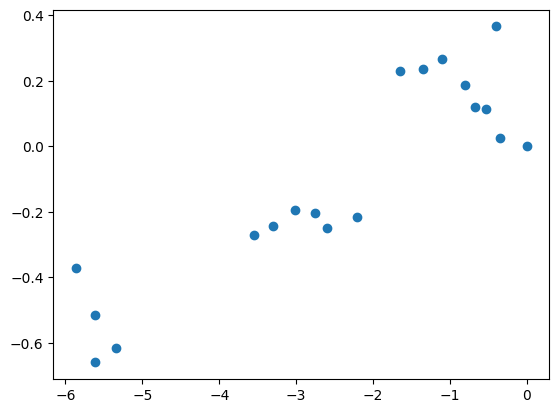

In [118]:
plt.scatter(pose_data[6][:, 0], pose_data[6][:, 1])

In [119]:
train_rmse = []
val_rmse = []

for epoch in range(num_epoch):
    start = time.time()
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss = val_epoch(model, val_loader, criterion)
    end = time.time()
    scheduler.step()
    print("Epoch: {}, Train Loss: {:.4f}, Val Loss: {:.4f}, Time: {:.4f}".format(epoch, train_loss, val_loss, end - start))

    train_rmse.append(train_loss)
    val_rmse.append(val_loss)

    

Epoch: 0, Train Loss: 24.7656, Val Loss: 9.1280, Time: 3.4305
Epoch: 1, Train Loss: 9.3010, Val Loss: 8.4914, Time: 3.6936
Epoch: 2, Train Loss: 8.4247, Val Loss: 7.8512, Time: 5.6181
Epoch: 3, Train Loss: 8.2330, Val Loss: 7.8725, Time: 4.3016
Epoch: 4, Train Loss: 8.1121, Val Loss: 8.1959, Time: 4.8871
Epoch: 5, Train Loss: 7.8177, Val Loss: 7.8388, Time: 5.1794
Epoch: 6, Train Loss: 7.6095, Val Loss: 8.2708, Time: 5.0500
Epoch: 7, Train Loss: 7.5973, Val Loss: 7.5716, Time: 5.0276
Epoch: 8, Train Loss: 7.4315, Val Loss: 8.0071, Time: 5.5474
Epoch: 9, Train Loss: 7.3854, Val Loss: 7.0414, Time: 5.2815
Epoch: 10, Train Loss: 7.2629, Val Loss: 6.9305, Time: 5.6418
Epoch: 11, Train Loss: 7.1574, Val Loss: 7.0846, Time: 5.4968
Epoch: 12, Train Loss: 7.0109, Val Loss: 7.1363, Time: 5.2871
Epoch: 13, Train Loss: 6.9953, Val Loss: 7.4043, Time: 5.5457
Epoch: 14, Train Loss: 7.0066, Val Loss: 6.7302, Time: 6.3690
Epoch: 15, Train Loss: 6.9140, Val Loss: 6.9078, Time: 5.4650
Epoch: 16, Train 

tensor([[[  0.0000,   0.0000],
         [ -0.0637,   0.7283],
         [ -0.0529,   1.6736],
         ...,
         [ -0.6193,  12.3940],
         [ -0.6177,  13.0247],
         [ -0.6843,  13.6604]],

        [[  0.0000,   0.0000],
         [  0.8340,   0.5404],
         [  1.5869,   1.1293],
         ...,
         [ 11.3821,  10.6522],
         [ 12.0457,  11.2867],
         [ 12.8005,  11.7386]],

        [[  0.0000,   0.0000],
         [ -1.1328,  -0.8409],
         [ -2.0193,  -1.6539],
         ...,
         [-15.7964, -12.9769],
         [-16.7397, -13.6390],
         [-17.6663, -14.5314]],

        ...,

        [[  0.0000,   0.0000],
         [ -0.4932,  -0.5211],
         [ -1.0156,  -1.0469],
         ...,
         [ -8.2971,  -8.3477],
         [ -8.8950,  -8.9811],
         [ -9.4768,  -9.4952]],

        [[  0.0000,   0.0000],
         [ -0.2012,  -0.4500],
         [ -0.4558,  -0.9000],
         ...,
         [ -5.7876,  -8.0066],
         [ -6.3281,  -8.5947],
         

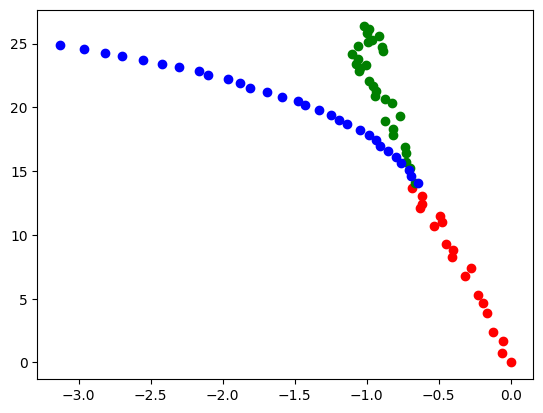

tensor([[[ 0.0000e+00,  0.0000e+00],
         [ 5.8618e-01,  5.4749e-01],
         [ 1.0864e+00,  9.9048e-01],
         ...,
         [ 8.5112e+00,  7.7787e+00],
         [ 9.0859e+00,  8.3173e+00],
         [ 9.4900e+00,  8.7355e+00]],

        [[ 0.0000e+00,  0.0000e+00],
         [ 2.2522e-02, -1.2417e+00],
         [ 7.4158e-02, -2.3091e+00],
         ...,
         [ 6.7169e-01, -2.0755e+01],
         [ 7.0648e-01, -2.1729e+01],
         [ 7.8015e-01, -2.2732e+01]],

        [[ 0.0000e+00,  0.0000e+00],
         [ 6.3599e-01,  1.8335e-01],
         [ 1.1833e+00,  3.2202e-01],
         ...,
         [ 8.3433e+00,  4.0276e+00],
         [ 8.7056e+00,  4.3903e+00],
         [ 9.3013e+00,  4.8156e+00]],

        ...,

        [[ 0.0000e+00,  0.0000e+00],
         [-1.1045e+00, -9.8840e-01],
         [-2.1292e+00, -1.9763e+00],
         ...,
         [-1.8488e+01, -1.7148e+01],
         [-1.9418e+01, -1.8312e+01],
         [-2.0650e+01, -1.9125e+01]],

        [[ 0.0000e+00,  0.0000e+00

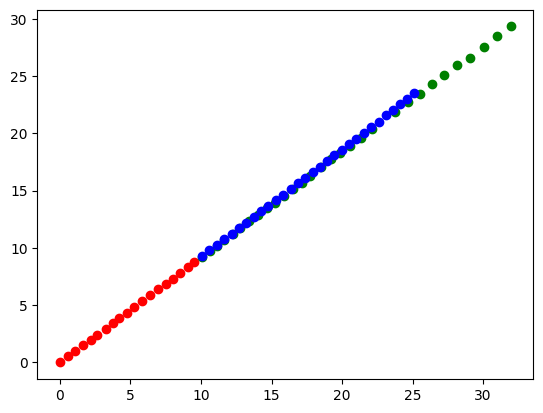

tensor([[[ 0.0000e+00,  0.0000e+00],
         [-6.6553e-01, -7.4060e-01],
         [-1.3853e+00, -1.2429e+00],
         ...,
         [-8.0571e+00, -7.4170e+00],
         [-8.6631e+00, -7.8981e+00],
         [-8.9673e+00, -8.2687e+00]],

        [[ 0.0000e+00,  0.0000e+00],
         [-9.7412e-01, -8.9734e-01],
         [-1.7981e+00, -1.6249e+00],
         ...,
         [-1.2473e+01, -1.1667e+01],
         [-1.3246e+01, -1.2371e+01],
         [-1.3246e+01, -1.2371e+01]],

        [[ 0.0000e+00,  0.0000e+00],
         [-7.2925e-01, -7.3230e-01],
         [-1.5759e+00, -1.5317e+00],
         ...,
         [-1.3915e+01, -1.2896e+01],
         [-1.4772e+01, -1.3732e+01],
         [-1.5680e+01, -1.4554e+01]],

        ...,

        [[ 0.0000e+00,  0.0000e+00],
         [-4.1162e-01, -1.3428e-01],
         [-1.1846e+00, -1.8848e-01],
         ...,
         [-7.4341e+00, -1.8572e+00],
         [-8.0400e+00, -2.0464e+00],
         [-8.5601e+00, -2.1428e+00]],

        [[ 0.0000e+00,  0.0000e+00

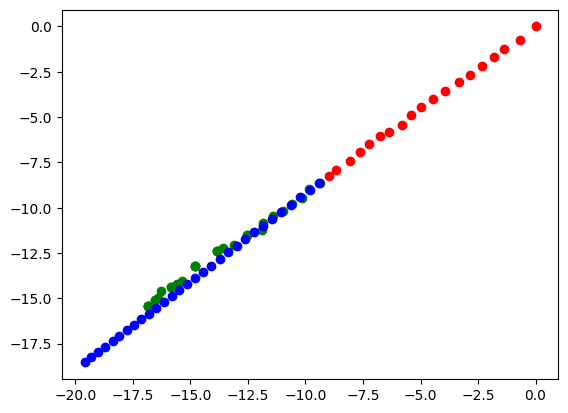

tensor([[[ 0.0000e+00,  0.0000e+00],
         [ 3.5278e-02, -1.2690e+00],
         [ 8.4351e-02, -2.5554e+00],
         ...,
         [ 3.5553e-01, -1.7519e+01],
         [ 4.1266e-01, -1.9090e+01],
         [ 4.2670e-01, -1.9855e+01]],

        [[ 0.0000e+00,  0.0000e+00],
         [ 6.8787e-02, -9.3518e-01],
         [ 1.4441e-01, -1.7992e+00],
         ...,
         [ 3.0591e-01, -1.5071e+01],
         [ 3.6890e-01, -1.6913e+01],
         [ 4.4073e-01, -1.7815e+01]],

        [[ 0.0000e+00,  0.0000e+00],
         [-8.0713e-01, -6.4819e-01],
         [-1.4563e+00, -1.4060e+00],
         ...,
         [-1.2443e+01, -1.1593e+01],
         [-1.3117e+01, -1.2202e+01],
         [-1.4741e+01, -1.3681e+01]],

        ...,

        [[ 0.0000e+00,  0.0000e+00],
         [-7.2632e-03, -4.0356e-01],
         [ 3.4180e-02, -8.1445e-01],
         ...,
         [ 3.5651e-01, -8.2195e+00],
         [ 3.2959e-01, -9.4656e+00],
         [ 3.3820e-01, -9.8267e+00]],

        [[ 0.0000e+00,  0.0000e+00

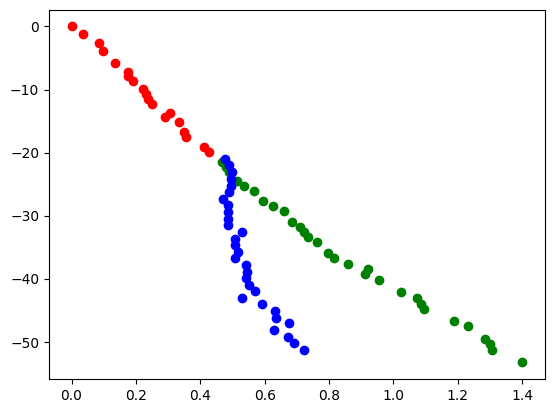

tensor([[[ 0.0000e+00,  0.0000e+00],
         [-9.0015e-01, -8.7842e-01],
         [-1.7563e+00, -1.5934e+00],
         ...,
         [-1.3163e+01, -1.2167e+01],
         [-1.3933e+01, -1.2941e+01],
         [-1.4770e+01, -1.3722e+01]],

        [[ 0.0000e+00,  0.0000e+00],
         [ 3.6365e-01,  2.9053e-02],
         [ 7.8601e-01,  4.8096e-02],
         ...,
         [ 7.8904e+00,  2.3530e+00],
         [ 8.2406e+00,  2.4644e+00],
         [ 8.8176e+00,  2.7219e+00]],

        [[ 0.0000e+00,  0.0000e+00],
         [ 1.0109e+00,  1.9775e-02],
         [ 1.9796e+00,  3.4180e-02],
         ...,
         [ 1.6734e+01,  1.1094e+00],
         [ 1.7881e+01,  1.1792e+00],
         [ 1.8889e+01,  1.2222e+00]],

        ...,

        [[ 0.0000e+00,  0.0000e+00],
         [ 1.1359e-01, -7.6221e-01],
         [ 1.2488e-01, -2.4808e+00],
         ...,
         [ 6.6455e-01, -1.5070e+01],
         [ 7.0459e-01, -1.5624e+01],
         [ 7.1075e-01, -1.6124e+01]],

        [[ 0.0000e+00,  0.0000e+00

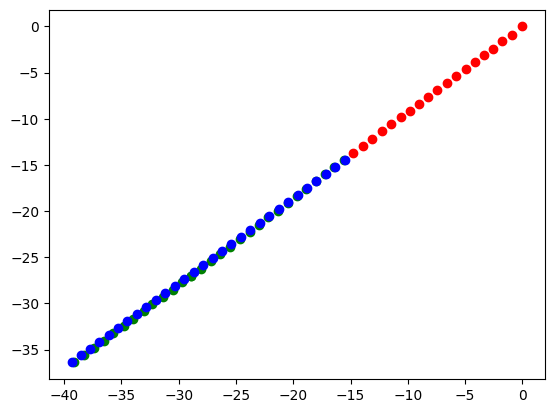

tensor([[[ 0.0000e+00,  0.0000e+00],
         [-5.8716e-02,  1.9775e-02],
         [-9.5032e-02,  1.7822e-02],
         ...,
         [-1.9756e+00, -1.0229e-01],
         [-2.6602e+00, -2.5562e-01],
         [-2.8296e+00, -2.1875e-01]],

        [[ 0.0000e+00,  0.0000e+00],
         [ 1.4172e+00,  3.0518e-02],
         [ 2.4729e+00,  3.8574e-02],
         ...,
         [ 2.0459e+01,  6.4771e-01],
         [ 2.1400e+01,  7.6514e-01],
         [ 2.3285e+01,  6.7896e-01]],

        [[ 0.0000e+00,  0.0000e+00],
         [ 2.5800e-01,  1.6357e-02],
         [ 1.6943e-01,  5.1025e-02],
         ...,
         [-2.4890e+00,  1.2646e+00],
         [-2.6094e+00,  1.4705e+00],
         [-2.3854e+00,  1.3657e+00]],

        ...,

        [[ 0.0000e+00,  0.0000e+00],
         [-3.8550e-01, -4.3237e-01],
         [-7.5757e-01, -6.3843e-01],
         ...,
         [-5.6523e+00, -5.7126e+00],
         [-6.0366e+00, -6.0344e+00],
         [-6.3413e+00, -6.3549e+00]],

        [[ 0.0000e+00,  0.0000e+00

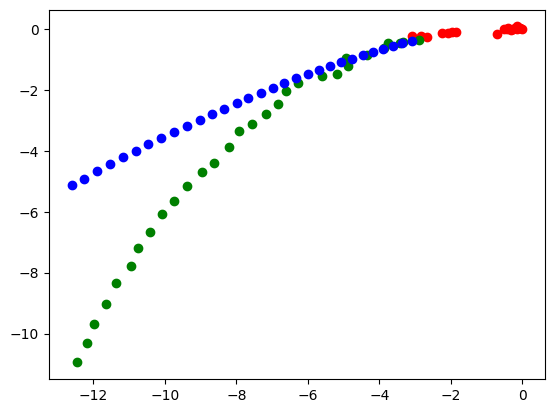

tensor([[[ 0.0000e+00,  0.0000e+00],
         [ 7.1631e-01,  4.0076e-01],
         [ 1.3044e+00,  1.2374e+00],
         ...,
         [ 1.1069e+01,  1.1326e+01],
         [ 1.1839e+01,  1.2083e+01],
         [ 1.2623e+01,  1.2992e+01]],

        [[ 0.0000e+00,  0.0000e+00],
         [-1.0679e+00, -9.5081e-01],
         [-2.2004e+00, -1.9873e+00],
         ...,
         [-1.7483e+01, -1.5944e+01],
         [-1.8549e+01, -1.6952e+01],
         [-1.9648e+01, -1.7990e+01]],

        [[ 0.0000e+00,  0.0000e+00],
         [-1.0919e-01,  1.2727e+00],
         [-2.8906e-01,  2.2864e+00],
         ...,
         [-5.1691e-01,  1.4557e+01],
         [-4.8846e-01,  1.5433e+01],
         [-5.3595e-01,  1.6265e+01]],

        ...,

        [[ 0.0000e+00,  0.0000e+00],
         [-4.0955e-02,  1.5076e+00],
         [-4.6631e-02,  2.9851e+00],
         ...,
         [-6.9690e-01,  2.4986e+01],
         [-7.5989e-01,  2.6639e+01],
         [-7.6678e-01,  2.8187e+01]],

        [[ 0.0000e+00,  0.0000e+00

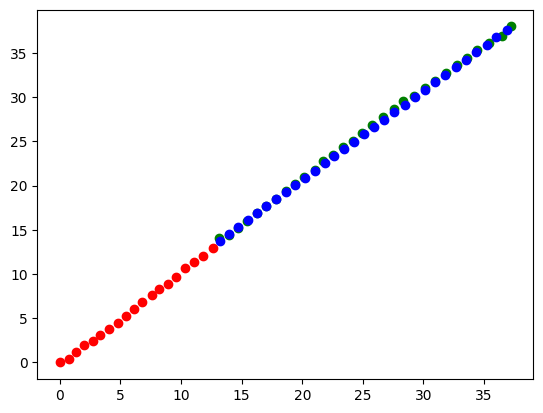

tensor([[[ 0.0000e+00,  0.0000e+00],
         [ 1.1274e+00,  1.0165e+00],
         [ 2.2117e+00,  2.0115e+00],
         ...,
         [ 1.8127e+01,  1.6544e+01],
         [ 1.9249e+01,  1.7561e+01],
         [ 2.0419e+01,  1.8645e+01]],

        [[ 0.0000e+00,  0.0000e+00],
         [-2.8586e-01,  1.5479e-01],
         [ 3.6774e-01,  1.9629e-01],
         ...,
         [ 1.4406e+00,  2.4121e-01],
         [ 1.8614e+00,  2.4780e-01],
         [ 2.3019e+00,  2.6318e-01]],

        [[ 0.0000e+00,  0.0000e+00],
         [ 8.0545e-01,  1.3647e-01],
         [ 7.9327e-01,  4.2554e-01],
         ...,
         [ 1.2173e+01, -4.2310e-01],
         [ 1.3337e+01, -3.3813e-01],
         [ 1.3676e+01, -3.6646e-01]],

        ...,

        [[ 0.0000e+00,  0.0000e+00],
         [-5.8551e-01,  8.5571e-01],
         [-9.8059e-01,  1.0862e+00],
         ...,
         [-8.3778e+00,  9.6396e+00],
         [-8.7715e+00,  1.0061e+01],
         [-9.1453e+00,  1.0255e+01]],

        [[ 0.0000e+00,  0.0000e+00

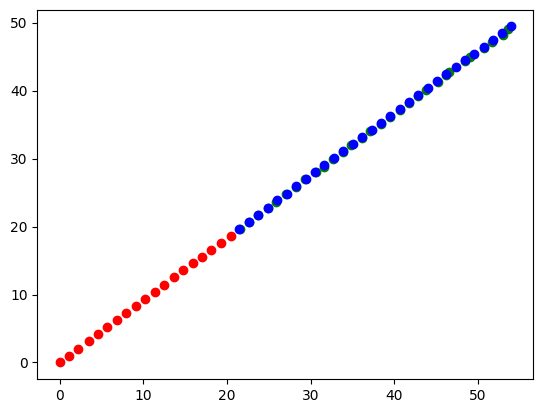

tensor([[[ 0.0000e+00,  0.0000e+00],
         [-4.1260e-02, -8.4351e-01],
         [-8.0322e-02, -1.6960e+00],
         ...,
         [-5.4559e-01, -1.3693e+01],
         [-7.1448e-01, -1.4284e+01],
         [-8.5547e-01, -1.5148e+01]],

        [[ 0.0000e+00,  0.0000e+00],
         [-2.7777e-01,  1.2214e+00],
         [-4.6918e-01,  2.3284e+00],
         ...,
         [-1.3149e+00,  2.3663e+01],
         [-1.7838e+00,  2.6073e+01],
         [-1.9099e+00,  2.6963e+01]],

        [[ 0.0000e+00,  0.0000e+00],
         [-2.1851e-01,  6.3062e-01],
         [-3.4644e-01,  1.3347e+00],
         ...,
         [-2.2659e+00,  1.0062e+01],
         [-2.1560e+00,  1.0631e+01],
         [-2.2434e+00,  1.1397e+01]],

        ...,

        [[ 0.0000e+00,  0.0000e+00],
         [ 4.3536e-01,  3.4912e-02],
         [ 1.1125e+00, -2.0996e-02],
         ...,
         [ 1.1320e+01,  4.7095e-01],
         [ 1.2039e+01,  4.2310e-01],
         [ 1.3024e+01,  2.1777e-01]],

        [[ 0.0000e+00,  0.0000e+00

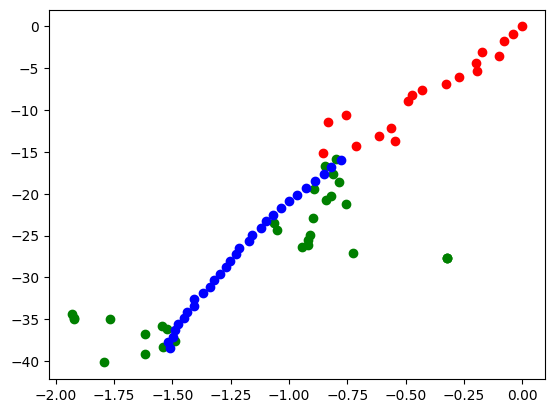

tensor([[[ 0.0000e+00,  0.0000e+00],
         [-9.2041e-01, -7.6648e-01],
         [-1.8459e+00, -1.5938e+00],
         ...,
         [-1.2946e+01, -1.1874e+01],
         [-1.3539e+01, -1.2516e+01],
         [-1.3986e+01, -1.2809e+01]],

        [[ 0.0000e+00,  0.0000e+00],
         [ 5.7434e-02, -1.6404e+00],
         [ 1.1176e-01, -3.1094e+00],
         ...,
         [ 7.3279e-01, -2.5466e+01],
         [ 8.5791e-01, -2.6578e+01],
         [ 7.9584e-01, -2.8365e+01]],

        [[ 0.0000e+00,  0.0000e+00],
         [ 6.8488e-01, -4.8828e-04],
         [ 2.0300e+00,  3.0029e-02],
         ...,
         [ 1.4947e+01,  3.2373e-01],
         [ 1.6912e+01,  4.2773e-01],
         [ 1.7645e+01,  4.4849e-01]],

        ...,

        [[ 0.0000e+00,  0.0000e+00],
         [ 2.0452e+00,  1.7944e+00],
         [ 3.0967e+00,  2.7120e+00],
         ...,
         [ 1.9574e+01,  1.7967e+01],
         [ 2.0875e+01,  1.9180e+01],
         [ 2.2984e+01,  2.1016e+01]],

        [[ 0.0000e+00,  0.0000e+00

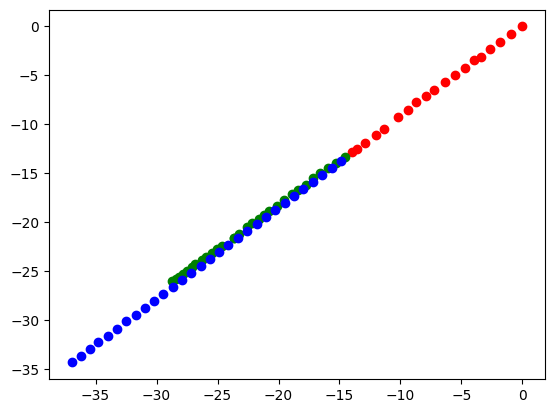

tensor([[[  0.0000,   0.0000],
         [ -0.3465,  -0.7231],
         [ -0.7496,  -1.5981],
         ...,
         [ -3.0188, -17.8879],
         [ -2.9937, -19.7007],
         [ -2.9417, -21.3030]],

        [[  0.0000,   0.0000],
         [  0.1812,  -0.9722],
         [  0.2627,  -2.1187],
         ...,
         [  0.6740, -18.9302],
         [  0.7481, -20.2314],
         [  0.7739, -21.4348]],

        [[  0.0000,   0.0000],
         [  0.0854,  -0.6086],
         [  0.0928,  -2.7104],
         ...,
         [  0.7531, -17.2986],
         [  0.8326, -18.4072],
         [  0.8021, -19.3037]],

        ...,

        [[  0.0000,   0.0000],
         [ -0.9207,  -0.8905],
         [ -1.9358,  -1.5521],
         ...,
         [-20.5100, -16.8819],
         [-21.5483, -17.7109],
         [-23.3701, -19.0750]],

        [[  0.0000,   0.0000],
         [ -0.2690,   0.1550],
         [ -0.8669,   0.0487],
         ...,
         [ -7.7500,   0.1426],
         [ -8.4028,  -0.0864],
         

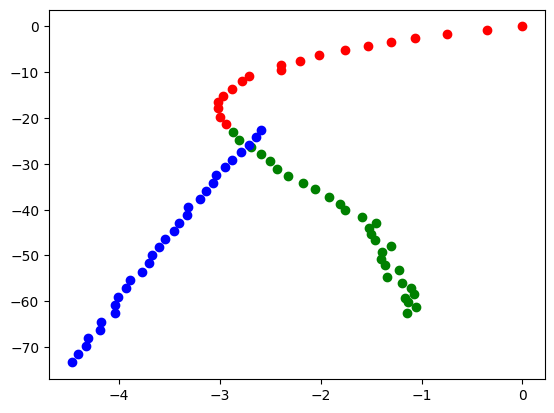

tensor([[[ 0.0000e+00,  0.0000e+00],
         [ 3.1201e-01, -3.5571e-01],
         [ 1.0020e+00, -1.2113e+00],
         ...,
         [ 5.6472e+00, -6.5532e+00],
         [ 5.9207e+00, -6.8718e+00],
         [ 6.3103e+00, -7.3011e+00]],

        [[ 0.0000e+00,  0.0000e+00],
         [-1.3347e+00, -4.1040e-01],
         [-1.7662e+00, -6.2671e-01],
         ...,
         [-1.0590e+01, -6.5408e+00],
         [-1.1379e+01, -7.4319e+00],
         [-1.1726e+01, -7.8678e+00]],

        [[ 0.0000e+00,  0.0000e+00],
         [ 1.9092e-01, -3.4766e-01],
         [ 1.1310e-01, -3.0029e-02],
         ...,
         [-9.1125e-02,  2.2463e+00],
         [-1.1823e-01,  2.7104e+00],
         [-1.3702e-01,  3.5520e+00]],

        ...,

        [[ 0.0000e+00,  0.0000e+00],
         [ 3.6499e-01,  3.7036e-01],
         [ 5.6763e-01,  6.7023e-01],
         ...,
         [ 3.9338e+00,  6.4894e+00],
         [ 4.0171e+00,  6.9417e+00],
         [ 4.1458e+00,  7.4203e+00]],

        [[ 0.0000e+00,  0.0000e+00

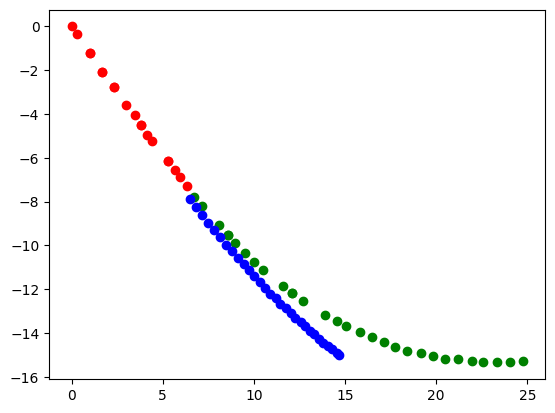

tensor([[[ 0.0000e+00,  0.0000e+00],
         [-4.8859e-02,  3.8818e-02],
         [-8.8196e-03,  5.9814e-02],
         ...,
         [ 3.8728e+00,  1.3159e-01],
         [ 4.7028e+00,  6.9824e-02],
         [ 5.6145e+00,  1.3037e-01]],

        [[ 0.0000e+00,  0.0000e+00],
         [-1.3715e-01,  2.1835e+00],
         [-2.0758e-01,  3.1710e+00],
         ...,
         [ 2.7203e-01,  1.9989e+01],
         [ 3.1879e-01,  2.0039e+01],
         [ 2.8900e-01,  2.1695e+01]],

        [[ 0.0000e+00,  0.0000e+00],
         [ 2.5085e-02, -1.3547e+00],
         [ 5.4199e-02, -2.7581e+00],
         ...,
         [ 6.5918e-01, -2.3554e+01],
         [ 7.7209e-01, -2.4470e+01],
         [ 8.6725e-01, -2.5625e+01]],

        ...,

        [[ 0.0000e+00,  0.0000e+00],
         [ 7.6685e-01,  7.0117e-01],
         [ 1.5608e+00,  1.4274e+00],
         ...,
         [ 1.2680e+01,  1.1865e+01],
         [ 1.3470e+01,  1.2569e+01],
         [ 1.4240e+01,  1.3310e+01]],

        [[ 0.0000e+00,  0.0000e+00

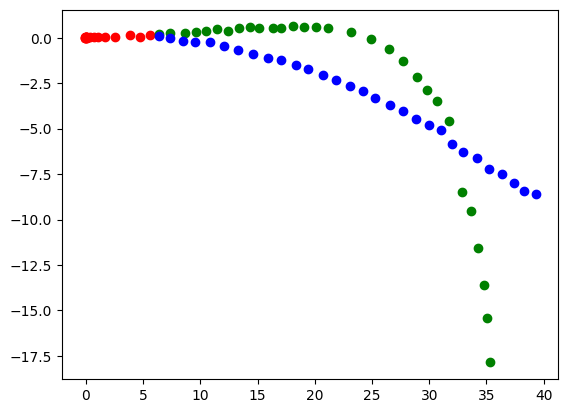

tensor([[[ 0.0000e+00,  0.0000e+00],
         [-2.8336e-02,  2.2480e+00],
         [-2.3547e-01,  3.9385e+00],
         ...,
         [-4.1380e-01,  2.0193e+01],
         [-5.5814e-01,  2.1544e+01],
         [-4.4792e-01,  2.2620e+01]],

        [[ 0.0000e+00,  0.0000e+00],
         [-8.4802e-01, -5.0028e+00],
         [-8.8391e-01, -5.4207e+00],
         ...,
         [-9.2303e-01, -1.1347e+01],
         [-1.1337e+00, -1.1956e+01],
         [-9.5367e-01, -1.2368e+01]],

        [[ 0.0000e+00,  0.0000e+00],
         [-3.6026e-02, -6.2976e-01],
         [-1.4282e-02, -1.3652e+00],
         ...,
         [ 2.8568e-01, -1.0407e+01],
         [ 3.2426e-01, -1.0874e+01],
         [ 3.4526e-01, -1.1430e+01]],

        ...,

        [[ 0.0000e+00,  0.0000e+00],
         [ 1.5146e+00,  1.2842e+00],
         [ 2.2458e+00,  1.8959e+00],
         ...,
         [ 2.0380e+01,  1.6211e+01],
         [ 2.1154e+01,  1.6829e+01],
         [ 2.2650e+01,  1.8029e+01]],

        [[ 0.0000e+00,  0.0000e+00

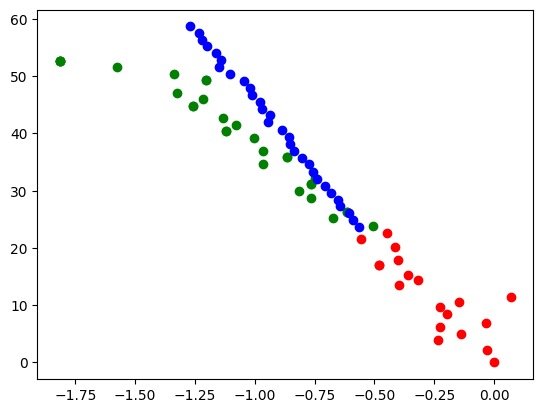

tensor([[[ 0.0000e+00,  0.0000e+00],
         [ 8.0786e-01,  6.1810e-01],
         [ 1.4343e+00,  1.2874e+00],
         ...,
         [ 1.2451e+01,  1.0858e+01],
         [ 1.3601e+01,  1.1609e+01],
         [ 1.4457e+01,  1.2399e+01]],

        [[ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [-1.7412e+00, -1.5481e+00],
         ...,
         [-1.3257e+01, -1.2518e+01],
         [-1.4131e+01, -1.3363e+01],
         [-1.5088e+01, -1.4146e+01]],

        [[ 0.0000e+00,  0.0000e+00],
         [-4.9988e-02, -3.0493e-01],
         [-1.3440e-01, -6.4917e-01],
         ...,
         [-4.3774e-01, -7.5359e+00],
         [-3.3618e-01, -8.1636e+00],
         [-2.7783e-01, -8.5867e+00]],

        ...,

        [[ 0.0000e+00,  0.0000e+00],
         [ 5.3271e-01,  8.3008e-03],
         [ 1.8721e+00,  1.1365e-01],
         ...,
         [ 1.3193e+01,  4.1553e-01],
         [ 1.3929e+01,  3.9221e-01],
         [ 1.4795e+01,  3.8086e-01]],

        [[ 0.0000e+00,  0.0000e+00

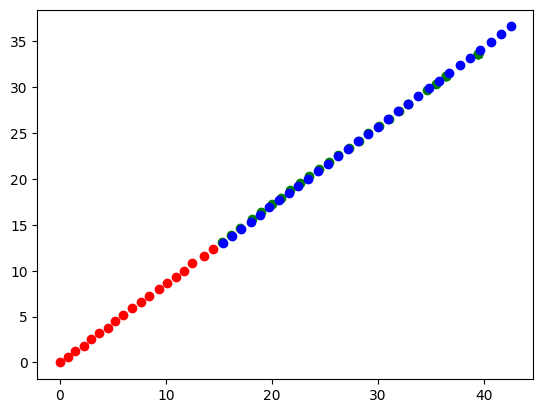

tensor([[[  0.0000,   0.0000],
         [ -0.0988,   1.4641],
         [ -0.0684,   2.5039],
         ...,
         [ -0.2697,  19.9121],
         [ -0.7253,  21.4604],
         [ -0.4918,  22.5769]],

        [[  0.0000,   0.0000],
         [  1.3096,   1.2188],
         [  1.9922,   1.8167],
         ...,
         [ 10.3433,   9.0742],
         [ 10.9846,   9.6428],
         [ 12.4109,  10.8757]],

        [[  0.0000,   0.0000],
         [ -0.0434,  -0.8855],
         [  0.1509,  -2.4814],
         ...,
         [  0.7796, -19.3213],
         [  0.8017, -20.5527],
         [  0.8174, -21.7566]],

        ...,

        [[  0.0000,   0.0000],
         [ -0.3599,   0.3455],
         [ -0.6567,   0.6274],
         ...,
         [ -6.1169,   6.5015],
         [ -6.4258,   6.8640],
         [ -6.7241,   7.2607]],

        [[  0.0000,   0.0000],
         [  0.4070,   0.4119],
         [  1.4478,   1.2529],
         ...,
         [  7.5134,   7.0530],
         [  7.8577,   7.5322],
         

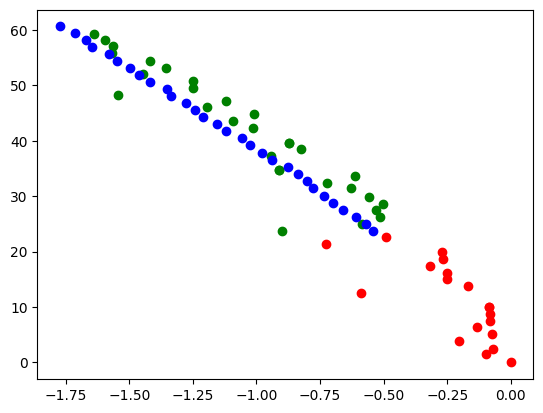

tensor([[[ 0.0000e+00,  0.0000e+00],
         [ 9.8999e-01,  8.7573e-01],
         [ 1.9688e+00,  1.7712e+00],
         ...,
         [ 1.5527e+01,  1.4013e+01],
         [ 1.6413e+01,  1.5079e+01],
         [ 1.7039e+01,  1.6033e+01]],

        [[ 0.0000e+00,  0.0000e+00],
         [-1.0808e+00, -7.9480e-01],
         [-1.8862e+00, -1.5978e+00],
         ...,
         [-1.2406e+01, -1.1544e+01],
         [-1.3548e+01, -1.2439e+01],
         [-1.4154e+01, -1.3022e+01]],

        [[ 0.0000e+00,  0.0000e+00],
         [-1.0942e+00, -1.1443e+00],
         [-2.3469e+00, -2.2288e+00],
         ...,
         [-1.9311e+01, -1.7564e+01],
         [-2.0280e+01, -1.8606e+01],
         [-2.1359e+01, -1.9775e+01]],

        ...,

        [[ 0.0000e+00,  0.0000e+00],
         [-4.7314e-01,  4.9512e-01],
         [-1.0215e+00,  9.6350e-01],
         ...,
         [-8.0303e+00,  8.1129e+00],
         [-8.3608e+00,  8.6599e+00],
         [-8.7986e+00,  9.1163e+00]],

        [[ 0.0000e+00,  0.0000e+00

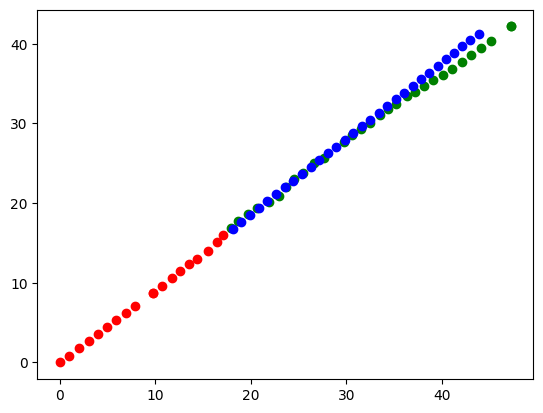

tensor([[[ 0.0000e+00,  0.0000e+00],
         [-6.6406e-02,  2.8943e-01],
         [-1.8188e-01,  1.4062e-01],
         ...,
         [ 2.3340e+00,  1.9456e+00],
         [ 2.7202e+00,  2.3898e+00],
         [ 3.1538e+00,  2.7589e+00]],

        [[ 0.0000e+00,  0.0000e+00],
         [-4.8462e-02, -1.5056e+00],
         [-8.4717e-02, -2.1982e+00],
         ...,
         [-7.9633e-01, -1.7264e+01],
         [-8.8251e-01, -1.8100e+01],
         [-8.4338e-01, -1.8945e+01]],

        [[ 0.0000e+00,  0.0000e+00],
         [-5.4468e-01,  4.3713e-01],
         [-1.1240e+00,  1.0251e+00],
         ...,
         [-9.2710e+00,  9.5452e+00],
         [-9.9060e+00,  1.0210e+01],
         [-1.0508e+01,  1.0881e+01]],

        ...,

        [[ 0.0000e+00,  0.0000e+00],
         [ 7.3425e-02, -9.5776e-01],
         [ 1.6016e-01, -1.5486e+00],
         ...,
         [ 7.1497e-01, -1.6080e+01],
         [ 7.3755e-01, -1.7047e+01],
         [ 7.6544e-01, -1.8109e+01]],

        [[ 0.0000e+00,  0.0000e+00

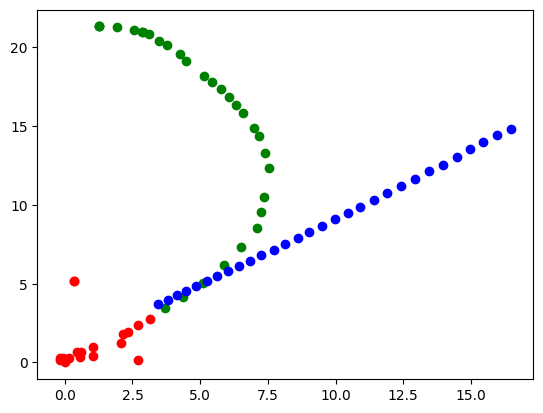

tensor([[[ 0.0000e+00,  0.0000e+00],
         [-1.0480e-01,  1.1028e+00],
         [ 2.1240e-01,  2.4460e+00],
         ...,
         [ 7.5250e-01,  2.1091e+01],
         [-5.3638e-01,  2.2592e+01],
         [-5.3638e-01,  2.2592e+01]],

        [[ 0.0000e+00,  0.0000e+00],
         [ 6.7444e-02, -9.2139e-01],
         [ 1.2921e-01, -2.0076e+00],
         ...,
         [ 4.4885e-01, -1.4312e+01],
         [ 3.9606e-01, -1.5775e+01],
         [ 3.2758e-01, -1.7548e+01]],

        [[ 0.0000e+00,  0.0000e+00],
         [-2.8856e-01, -4.6387e-02],
         [-9.6292e-01, -8.0078e-02],
         ...,
         [-9.0237e+00, -4.4287e-01],
         [-9.5375e+00, -4.6973e-01],
         [-1.0256e+01, -4.7827e-01]],

        ...,

        [[ 0.0000e+00,  0.0000e+00],
         [-1.0376e-03, -4.5972e-01],
         [-3.1418e-02, -8.9990e-01],
         ...,
         [-1.6045e-01, -7.3391e+00],
         [-2.3625e-01, -7.9270e+00],
         [-1.4720e-01, -8.4810e+00]],

        [[ 0.0000e+00,  0.0000e+00

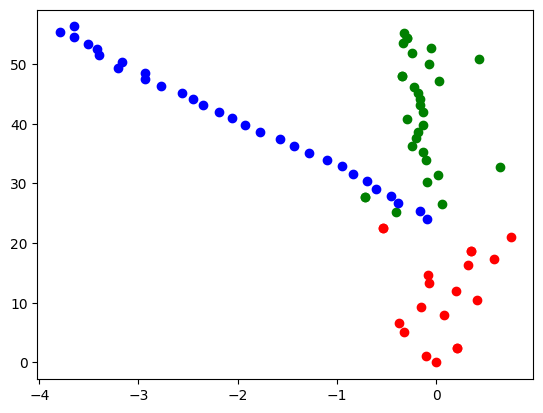

tensor([[[ 0.0000e+00,  0.0000e+00],
         [-4.7879e-01, -2.0264e-02],
         [-2.2036e+00, -1.1133e-01],
         ...,
         [-1.5087e+01, -1.0493e+00],
         [-1.5972e+01, -1.0955e+00],
         [-1.6843e+01, -1.1794e+00]],

        [[ 0.0000e+00,  0.0000e+00],
         [ 2.4365e-01,  8.2397e-02],
         [ 4.5825e-01,  1.8872e-01],
         ...,
         [ 1.7439e+00,  1.5145e+00],
         [ 1.8000e+00,  1.4954e+00],
         [ 1.8845e+00,  1.6173e+00]],

        [[ 0.0000e+00,  0.0000e+00],
         [-1.1411e+00, -3.1494e-02],
         [-2.1043e+00, -1.3489e-01],
         ...,
         [-1.5737e+01, -8.6499e-01],
         [-1.6745e+01, -8.6450e-01],
         [-1.7740e+01, -9.2334e-01]],

        ...,

        [[ 0.0000e+00,  0.0000e+00],
         [-5.7983e-01,  5.8569e-01],
         [-1.0583e+00,  1.1515e+00],
         ...,
         [-8.5359e+00,  9.0057e+00],
         [-9.0457e+00,  9.5421e+00],
         [-9.3367e+00,  1.0126e+01]],

        [[ 0.0000e+00,  0.0000e+00

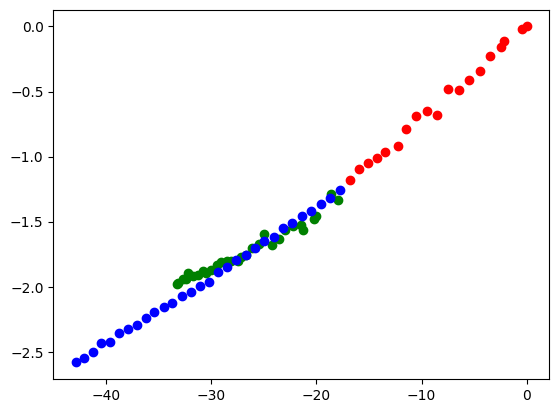

In [120]:
for i, (inp, tgt) in enumerate(train_loader):
    if i == 20:
        break
    inp = inp.to(device)
    tgt = tgt.to(device)
    print(inp)
    print(tgt)

    pred = model(inp)


    plt.scatter(inp[0, :, 0].cpu().numpy(), inp[0, :, 1].cpu().numpy(), color = 'red')
    plt.scatter(tgt[0, :, 0].cpu().numpy(), tgt[0, :, 1].cpu().numpy(), color = 'green')
    plt.scatter(pred[0, :, 0].detach().cpu().numpy(), pred[0, :, 1].detach().cpu().numpy(), color = 'blue')
    plt.show()

In [121]:
test_path = "./../data/val_in/"
test_pkl_list = glob(os.path.join(test_path, '*'))
test_pkl_list.sort()

test_preds = []
for idx in range(len(test_pkl_list)):
    with open(test_pkl_list[idx], 'rb') as f:
        test_sample = pickle.load(f)
        pred_id = np.where(test_sample["track_id"] == test_sample['agent_id'])[0][0]
        inp_scene = np.dstack([test_sample['p_in'], test_sample['v_in']])

        # Normalization 
        min_vecs = np.min(inp_scene, axis = (0,1))
        max_vecs = np.max(inp_scene, axis = (0,1))
        
        inp = inp_scene[pred_id]
        inp = inp[:, :2] - inp[0, :2]
        
        inp = torch.from_numpy(inp).float().to(device).unsqueeze(0)

        preds = model(inp).cpu().data.numpy()
        
        # De-Normalization ! 
        preds = preds + inp[0, 0, :2].cpu().data.numpy()
        test_preds.append(preds)

In [122]:
# # Submission Files
sample_sub = pd.read_csv('./../submissions/sample_submission.csv')

In [123]:
# Convert to int
predictions = np.concatenate(test_preds).reshape(len(test_preds), -1).astype(int)
sub_df = pd.DataFrame(np.c_[sample_sub["ID"], predictions], columns=[np.r_[["ID"], ["v" + str(i) for i in range(1, 61)]]])
sub_df.to_csv('test_submission_mlp.csv', index=None)

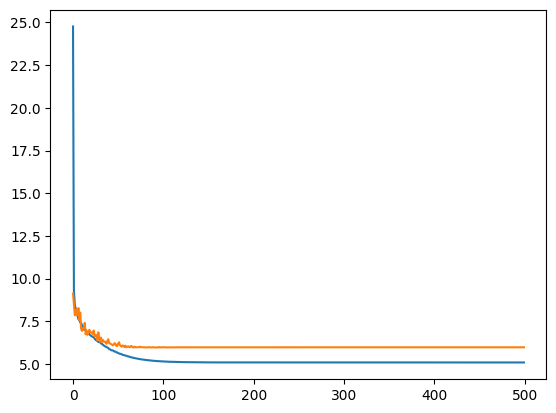

In [124]:
plt.plot(train_rmse, label = "Train RMSE")
plt.plot(val_rmse, label = "Val RMSE")

In [125]:
test_path = "./../data/val_in/"
test_pkl_list = glob(os.path.join(test_path, '*'))
test_pkl_list.sort()

In [126]:
with open(test_pkl_list[0], 'rb') as f:
        test_sample = pickle.load(f)

inp = test_sample['p_in'][0]
lanes = test_sample['lane']

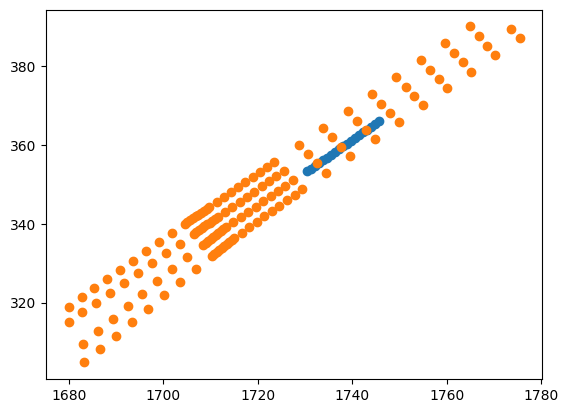

In [127]:
plt.scatter(inp[:, 0], inp[:, 1])
plt.scatter(lanes[:, 0], lanes[:, 1])
